In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = 18, 8
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
# matplotlib.rcParams['xtick.labelsize'] = 12
# matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

import warnings
warnings.filterwarnings("ignore")
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

import pmdarima as pm

from scipy.stats.stats import pearsonr
from statsmodels.tsa.statespace.varmax import VARMAX

from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.statespace.sarimax import SARIMAX


from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout

from sklearn.ensemble import IsolationForest

Using TensorFlow backend.


# Configuration

In [2]:
# directory of data file
PATH = 'data/data.xlsx'\

# target variables' row number from excel
TARGET_ROWS = [10, 11, 17, 19]

# number of steps to predict
STEPS_TO_PREDICT = 12

# corresponnding models to each variables with corresponding hyperparameter inputs, and threshold & target value. 
# AS IN ('MODEL_Hyperparameters', THRESHOLD, TARGET, SMOOTH?)
MODELS = {
    'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon': ('LSTM_4_32', 10, 5, True),
    'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon': ('LSTM_4_32', 450, 300, True),
    'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)': ('AUTO', 500, 330, True),
    'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)': ('AUTO', 25, 18, True)
#     Average revenue per new customer - Falcon (10, 5) __ 
#     Average revenue per existing customer - Falcon (450, 300) __ 
#     Gross Adds - Falcon(Norm) (AUTO, 500, 330) __ SARIMAX(2.200876812472711)  AUTO_m4(1.810907825611017)  AUTO_m12_sm(1.867899924506245)  AUTO_m4_sm(1.4911606149126928)
#     Net Migrations - Falcon(Norm) (AUTO, 25, 18) __ SX_sm(0.21548350609085498)  AUTO_m12_sm(0.176919414737572)  AUTO_m4_sm(0.176919414737572)
}

# Read file

In [3]:
def read_file():
    '''
    Reads the challenge data 'Sandesh' and preprocess it:
        -tranpose the raw data
        -set datetime as index 
        -set 'Generic_LookupKeys' as columns
        -remove descriptive rows
        
    Input: NA.
    Output: full_data, target_data(with only target variables)
    
    '''

    data_df = pd.read_excel(PATH)
    

    Target_Generic_LookupKeys = list(data_df.iloc[[x-2 for x in TARGET_ROWS], 7])
    Generic_LookupKeys = list(data_df.iloc[2:,7])


    #dropping the descriptive rows and reset index and columns
    full_data = data_df.T.iloc[9:,2:]
    full_data.set_index(pd.date_range(start='2016/04/01', periods=48, freq='MS'), inplace=True)
    full_data.columns = Generic_LookupKeys

    #last six months hold for testing
    test_data = full_data.replace('x', np.nan).dropna(how='all')[Target_Generic_LookupKeys]['2019-10-01':]

    #drop x marks and nan
    full_data = full_data.replace('x', np.nan).dropna(how='all').truncate(after= '2019-09-01')

    # dataframe with all the target lookupkeys
    target_data = full_data[Target_Generic_LookupKeys].dropna(how='all')

    
    
    return full_data, target_data, test_data

# Helper functions

In [4]:
'''
HELPER FUNCTIONS
'''

# # smooth out anomalies
# def smooth(target_data):
    
#     from adtk.data import validate_series
#     from adtk.visualization import plot
#     from adtk.detector import AutoregressionAD
#     from adtk.transformer import RollingAggregate

#     s_train = validate_series(target_data)

#     quantile_ad = AutoregressionAD(n_steps=12, step_size=1, c=0.6)
#     anomalies = quantile_ad.fit_detect(s_train)
#     # plot(s_train, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");
#     target_data[anomalies == 1] = np.nan
#     target_data.interpolate(inplace = True)
 
#     return target_data


# smooth out anomalies
def smooth(full_data):
    
#     for i in full_data.columns:
#         full_data[i] = outlier_smoothing(full_data[i].dropna(), plot=False)
        
    for i in full_data.columns:
        if MODELS[i][3]:
            full_data[i] = outlier_smoothing(full_data[i].dropna(), plot=False)
 
    return full_data


def outlier_smoothing(X, contamination=0.15, smoothing_window=4, plot=True, random_state=22, verbose=True):
    """
    Outlier identification by IForest and 
    smoothing by rolling window median value
    """
    X_rolling_median = X.rolling(smoothing_window).median()
    X_rolling_mean = X.rolling(smoothing_window).mean()
    X_smoothing_ratio = X / X_rolling_median

    if plot:
        plt.figure(figsize=(10,10))
        plt.plot(X.index, X, label='original')
        plt.plot(X.index, X_rolling_median, label='rolling median')
        plt.title("Original vs. Rolling Median")
        plt.legend()
        plt.show()

        plt.figure(figsize=(10,10))
        plt.plot(X.index, X_smoothing_ratio, label="original:smoothing ratio")
        plt.title("Smoothing Ratio")
        plt.legend()
        plt.show()
    
    ## Find the outliers
    iso_forest = IsolationForest(contamination=contamination,\
        random_state=random_state)
    peaks = np.where(iso_forest.fit_predict(X_smoothing_ratio[smoothing_window-1:].\
        values.reshape(-1,1))<1)
    if verbose:
        print("Outliers found at ", X.index[peaks[0]+smoothing_window-1])
    if plot:
        plt.figure(figsize=(10,10))
        plt.plot(X.index, X, label='original')
        plt.plot(X.index.values[peaks[0]+smoothing_window-1],\
            X.values[peaks[0]+smoothing_window-1], 'x'
            )
        plt.title("Outlier Finders")
        plt.legend()
        plt.show()
    ## Change the outliers with corresponding smoothed values    
    X_smoothed = X.copy()

    for i in range(len(X)):
        if np.any(peaks[0]+smoothing_window-1==i):
            X_smoothed[i] = X_rolling_mean[i]

    if plot:
        plt.figure(figsize=(10,10))
        plt.plot(X.index, X, label='original')
        plt.plot(X.index, X_smoothed, label='smoothed')
        plt.title("Original vs. smoothed")
        plt.legend()
        plt.show()
    
    return X_smoothed



#Quantitative Scoring using MAPE
def MAPE(gt, pred):
    mape = []

    for g, p in zip(gt, pred):
        mape.append(abs((g-p)/g))
#         mape.append(max(0, 1 - abs((g-p)/g)))

    return mape


def Max_APE(gt, pred):
    """
    Returns max absolute percentage error
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.max(np.abs((y_true - y_pred) / y_true)) * 100


def RMSE(y_true, y_pred):
    """
    Returns root mean square error
    """
    return np.sqrt(np.mean((y_true - y_pred)**2))


import itertools
import statsmodels.api as sm

def best_parameters_sarimax(series, exog=None):
    '''
    Finds the best parameters for a given series for SARIMAX algorithm.
    Input: series: the series for which the parameters are to be determined.
            exog: extra features to be considered, here price increase related
    Output: the best parameters for the series and model.
    '''
    result_param = -1
    result_param_seasonal = -1
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(series,
                                                exog=exog,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
                try:
                    if results.aic < minimum:
                        result_param = param
                        result_param_seasonal = param_seasonal
                except:
                    result_param = param
                    result_param_seasonal = param_seasonal
                    minimum = results.aic
            except:
                continue
    return result_param, result_param_seasonal

def apply_model_sarimax(series, best_param, best_param_seasonal, exog=None):
    '''
    Makes and trains SARIMAX model on the given series and parameters.
    Input:  series: series on which the model is to be trained.
            best_param, best_param_seasonal: best parameters for modelling
    Output: Trained model
    '''
    
    mod = sm.tsa.statespace.SARIMAX(series,
                                    exog=exog,
                                    order=best_param,
                                    seasonal_order=best_param_seasonal,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()
    return results

def create_dataset(dataset, look_back=1):
    '''
    Convert an array of values into a dataset matrix
    Input: Array data
    Output: reshape into X=t, Y=t+1 (the next timestamp)
    '''
    dataset = dataset.reshape(dataset.shape[0], 1)
    
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Models

In [5]:
def train_and_predict_autoArima(train_df, generic_lookup, number_of_steps_to_predict):
    '''
    Train with autoARIMA to do stepwise search for best params automatically
    Input: train_df- training dataframe.
            generic_lookup- the generic_llokup for which we are going to predict.
            number_of_steps_to_predict.
    Output: Forecasts.
    '''
    
    try:
#         auto = pm.auto_arima(train_df[generic_lookup], start_p=1, start_q=1, max_p=3, max_q=3,
#                        start_P=0, seasonal=False, d=1, D=1, trace=False,
#                        error_action='ignore',  
#                        suppress_warnings=True, 
#                        stepwise=True)
#         print(train_df[generic_lookup])
        auto = pm.auto_arima(train_df[generic_lookup], error_action='ignore', seasonal=True, m=4)#, max_D=12)


        forecast = auto.predict(number_of_steps_to_predict).tolist()
        return forecast

    except Exception as e: print(e)

In [6]:
def train_and_predict_sarimax(train_df, generic_lookup, number_of_steps_to_predict, exog = None):
    '''
    Train a SARIMAX and predicts on the validation data.
    Input:  train_df- training dataframe.
            generic_lookup- the generic_llokup for which we are going to predict.
            number_of_steps_to_predict
    Output: Forecasts.
    '''
   
    try:
            
#             if "leaver" in generic_lookup.lower():
#                 best_param = (1,1,1)
#                 best_param_seasonal = (1,0,0,12)
#             elif "gross" in generic_lookup.lower():
#                 best_param = (1,1,1)
#                 best_param_seasonal = (1,1,0,12)
#             else:
        best_param, best_param_seasonal = best_parameters_sarimax(train_df[generic_lookup])

        print('best params from SARIMAX:{}, seasonal: {}'.format(best_param, best_param_seasonal))
        results = apply_model_sarimax(train_df[generic_lookup], best_param, best_param_seasonal)
        forecast = results.get_forecast(steps=number_of_steps_to_predict)
        forecast = forecast.predicted_mean.tolist()
        return forecast

    except Exception as e: print(e)

In [7]:
@ignore_warnings(category=ConvergenceWarning)
def train_and_predict_LSTM(train_df, generic_lookup, number_of_steps_to_predict, look_back=1, units=32):
    '''
    Train with LSTM and predicts on the validation data.
    Input:  train_df- training dataframe.
            generic_lookup- the generic_llokup for which we are going to predict.
            number_of_steps_to_predict.
    Output: Forecasts
    '''

    params = MODELS[generic_lookup][0].split('_')
    if len(params) > 1:
        look_back = int(params[1])
    if len(params) > 2:
        units = int(params[2])


    trainX, trainY = create_dataset(train_df[generic_lookup].values, look_back)
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(units=units, return_sequences= True,input_shape=( 1,look_back)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=units))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=300, batch_size=20, verbose=0)



    testX = np.array([trainY[-look_back:]])

    forecast = []

    try:
        for i in range(0,number_of_steps_to_predict):
            #print(testX)
            testX = np.reshape(testX, (testX.shape[0], 1, look_back))
            testPredict = model.predict(testX)

            testX = np.roll(testX, -1)
            testX[0][0][look_back - 1] = testPredict[0][0]

            forecast.append(testPredict[0][0])

        return forecast
    
    except Exception as e: print(e)

# Cross Val & Model Comparison

In [8]:
@ignore_warnings(category=ConvergenceWarning)
def cross_validation_and_model_comparison(train_df, number_of_steps_to_predict, generic_lookup):#, ROBUST_TEST=True):
    
    

    '''
    Making forecasts
    ''' 
    
    #   Auto_Armia
    if MODELS[generic_lookup][0].startswith('AUTO'):
        print(f'\"{MODELS[generic_lookup][0]}\" for \"{generic_lookup}\"')
        forecast = train_and_predict_autoArima(train_df, generic_lookup, number_of_steps_to_predict)

    #   SARIMAX
    elif MODELS[generic_lookup][0].startswith('SARIMAX'):
        print(f'\"{MODELS[generic_lookup][0]}\" for \"{generic_lookup}\"')
        forecast = train_and_predict_sarimax(train_df, generic_lookup, number_of_steps_to_predict)

    #   LSTM
    elif MODELS[generic_lookup][0].startswith('LSTM'):
        print(f'\"{MODELS[generic_lookup][0]}\" for \"{generic_lookup}\"')
        forecast = train_and_predict_LSTM(train_df, generic_lookup, number_of_steps_to_predict)

    #   default
    else:
        forecast = -1
        
    
        
    return forecast

# Make Prediction

In [9]:
@ignore_warnings(category=ConvergenceWarning)
def make_predictions(target_data):
    '''
    The parent function to join correlated features, get number of steps, does cross validation and compares models.
    Input:  submission: submission dataframe.
            train: train dataframe.
            related_features: dictionary of related features.
    Output: Full forecast for all the generic lookup.
    '''
    # Initialize a list for all generic lookup.
    full_forecast = {}

    
    # For every generic lookup in submission.
    for generic_lookup in target_data.columns:
        
        
#         print(f"generic lookup: {generic_lookup}")
        train_df = pd.DataFrame()
        series_data = target_data[generic_lookup].dropna().tolist()
        train_df[generic_lookup] = series_data
        train_df.set_index(target_data[generic_lookup].dropna().index, inplace =True)

        # Join all correlated features to dataframe of this generic lookup
#         train_df = join_related_features(train_df, full_data, related_features, generic_lookup)
#         print(f"joined shape : {train_df.shape}")
        

        # Get number of steps to predict for this generic lookup
        number_of_steps_to_predict = STEPS_TO_PREDICT

    
        # Check cross validation and do final prediction.
        forecast = cross_validation_and_model_comparison(train_df, number_of_steps_to_predict, generic_lookup)#, ROBUST_TEST=False)
     
    
        if forecast == -1:
            print("MODEL FAILED")
            forecast = [train_df[generic_lookup].mean()]*number_of_steps_to_predict
            
        full_forecast.setdefault(generic_lookup, []).append(forecast)
        

    
    return full_forecast

# Output file

In [10]:
def make_submission(forecasts, target_data):
    '''
    
    Input: forecasts, target dataset
    Output: 2*6*12 by 3 submission formated 
    '''
    df = []
    
    for col in target_data.columns:
        temp = pd.DataFrame()
        temp['values'] = forecasts[col][0]
        temp['Generic_LookupKey'] = col
        temp['date'] = pd.date_range(start='2019/10/01', periods=STEPS_TO_PREDICT, freq='MS')
        df.append(temp)
        
    return pd.concat(df)

# Evaluation

In [11]:
def evaluate(pred, gt, train_data, plot = True):
    
    pd.plotting.register_matplotlib_converters()
    matplotlib.rcParams['figure.figsize'] = 18, 8
    
    final_raw_score = []
    final_threshold_score = []
    
    for i in gt.columns:
        
        mape = MAPE(gt[i], pred[i][0][:6])
        raw_score = np.mean([max(0, 1 - m) for m in mape])
        
        if np.mean(mape) <  MODELS[i][1]/100:
            if np.mean(mape) <  MODELS[i][2]/100:
                threshold_score = 0.07
            else:
                threshold_score = 0.03
        else:
            threshold_score = 0
            
        print(f"For \"{i[30:]}\" with model \"{MODELS[i][0]}\"")
        print(f"MAPE : {np.mean(mape)}")
        print(f"Threshold : {MODELS[i][1]/100},  Target: {MODELS[i][2]/100}")
        print(f"Raw score : {raw_score}")
        print(f"Threshold score : {threshold_score}")
        
        final_raw_score.append(raw_score)
        final_threshold_score.append(threshold_score)
        
        if plot:
            plt.figure()
            plt.title(i[69:])
            
            temp = pd.DataFrame()
            temp[i] = pred[i][0]
            temp.set_index(pd.date_range(start='2019/10/01', periods=12, freq='MS'), inplace=True)

            train_data[i].plot()
            gt[i].plot(color = 'red')
            temp[i].plot(color = 'green')
            
            plt.show()
            
            
    print(f"Final Raw score : {np.mean(final_raw_score)}")
    print(f"Final Threshold score : {np.sum(final_threshold_score)}")

# Robustness

In [12]:
def robust(train_data):
    '''
    making robustness predictions
    '''

    for i in range(12, 6, -1):
#         print(i)
#         print(train_data.truncate(after=train_data.index[-i]).index)
        robust_forecast = make_predictions(train_data.truncate(after=train_data.index[-i]))
        submission = make_submission(robust_forecast, train_data)
        submission.to_csv(f'robust/submission{i-6}.csv', index=False)

# Main

In [13]:
if __name__ == '__main__':
    
    print('Reading files')
    full_data, target_data, test_data = read_file()
    smooth(target_data)    
    
#     print('Making full forecast')
    full_forecasts = make_predictions(target_data)

Reading files


C:\Users\waynn\.conda\envs\tensorflow_cpu\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.



Outliers found at  DatetimeIndex(['2017-04-01', '2018-05-01', '2018-08-01', '2018-09-01',
               '2019-05-01', '2019-06-01'],
              dtype='datetime64[ns]', freq=None)


C:\Users\waynn\.conda\envs\tensorflow_cpu\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.



Outliers found at  DatetimeIndex(['2016-11-01', '2017-01-01', '2017-02-01', '2017-03-01',
               '2018-07-01', '2018-08-01'],
              dtype='datetime64[ns]', freq=None)


C:\Users\waynn\.conda\envs\tensorflow_cpu\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.



Outliers found at  DatetimeIndex(['2017-02-01', '2017-12-01', '2018-01-01', '2018-12-01',
               '2019-04-01', '2019-05-01'],
              dtype='datetime64[ns]', freq=None)


C:\Users\waynn\.conda\envs\tensorflow_cpu\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.



Outliers found at  DatetimeIndex(['2017-04-01', '2018-03-01', '2018-11-01', '2019-02-01',
               '2019-03-01', '2019-09-01'],
              dtype='datetime64[ns]', freq=None)
"LSTM_4_32" for "Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon"
"LSTM_4_32" for "Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon"
"AUTO" for "Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)"


C:\Users\waynn\.conda\envs\tensorflow_cpu\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



"AUTO" for "Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)"


C:\Users\waynn\.conda\envs\tensorflow_cpu\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\waynn\.conda\envs\tensorflow_cpu\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [16]:
submission = make_submission(full_forecasts, target_data)
submission.to_csv('output/prediction.csv', index=False)

In [17]:
robust(target_data)

"LSTM_4_32" for "Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon"
"LSTM_4_32" for "Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon"
"AUTO" for "Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)"


C:\Users\waynn\.conda\envs\tensorflow_cpu\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\waynn\.conda\envs\tensorflow_cpu\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



"AUTO" for "Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)"


C:\Users\waynn\.conda\envs\tensorflow_cpu\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\waynn\.conda\envs\tensorflow_cpu\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



"LSTM_4_32" for "Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon"
"LSTM_4_32" for "Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon"
"AUTO" for "Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)"


C:\Users\waynn\.conda\envs\tensorflow_cpu\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\waynn\.conda\envs\tensorflow_cpu\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



"AUTO" for "Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)"


C:\Users\waynn\.conda\envs\tensorflow_cpu\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\waynn\.conda\envs\tensorflow_cpu\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



"LSTM_4_32" for "Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon"
"LSTM_4_32" for "Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon"
"AUTO" for "Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)"


C:\Users\waynn\.conda\envs\tensorflow_cpu\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\waynn\.conda\envs\tensorflow_cpu\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



"AUTO" for "Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)"


C:\Users\waynn\.conda\envs\tensorflow_cpu\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



"LSTM_4_32" for "Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon"
"LSTM_4_32" for "Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon"
"AUTO" for "Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)"


C:\Users\waynn\.conda\envs\tensorflow_cpu\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\waynn\.conda\envs\tensorflow_cpu\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



"AUTO" for "Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)"


C:\Users\waynn\.conda\envs\tensorflow_cpu\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\waynn\.conda\envs\tensorflow_cpu\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\waynn\.conda\envs\tensorflow_cpu\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\waynn\.conda\envs\tensorflow_cpu\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



"LSTM_4_32" for "Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon"
"LSTM_4_32" for "Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon"
"AUTO" for "Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)"


C:\Users\waynn\.conda\envs\tensorflow_cpu\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\waynn\.conda\envs\tensorflow_cpu\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



"AUTO" for "Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)"


C:\Users\waynn\.conda\envs\tensorflow_cpu\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\waynn\.conda\envs\tensorflow_cpu\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\waynn\.conda\envs\tensorflow_cpu\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\waynn\.conda\envs\tensorflow_cpu\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



"LSTM_4_32" for "Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon"
"LSTM_4_32" for "Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon"
"AUTO" for "Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)"


C:\Users\waynn\.conda\envs\tensorflow_cpu\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\waynn\.conda\envs\tensorflow_cpu\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



"AUTO" for "Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)"


C:\Users\waynn\.conda\envs\tensorflow_cpu\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



For "desh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon" with model "LSTM_4_32"
MAPE : 0.17378380556572226
Threshold : 0.1,  Target: 0.05
Raw score : 0.8262161944342777
Threshold score : 0


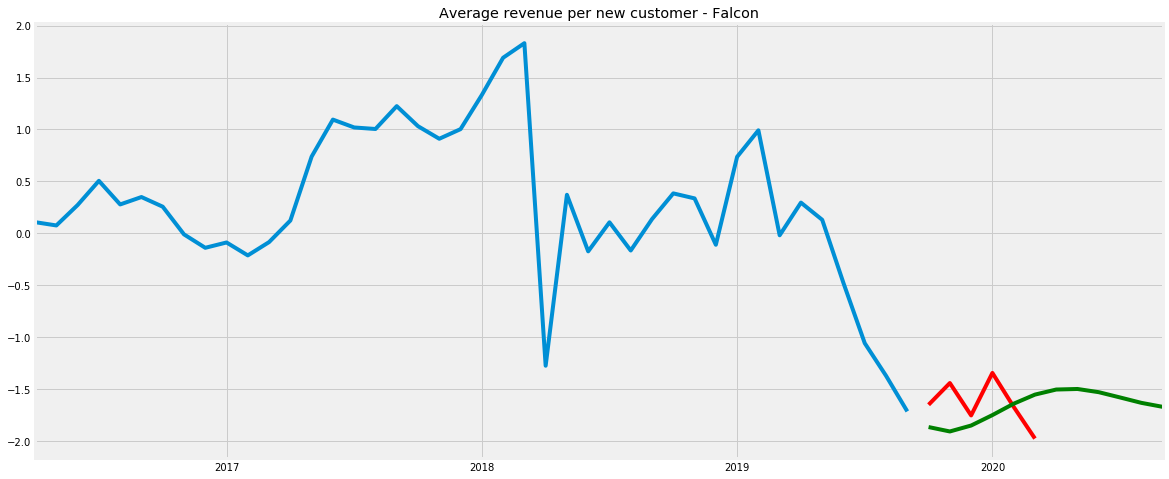

For "desh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon" with model "LSTM_4_32"
MAPE : 2.5231979613573463
Threshold : 4.5,  Target: 3.0
Raw score : 0.30755401392220866
Threshold score : 0.07


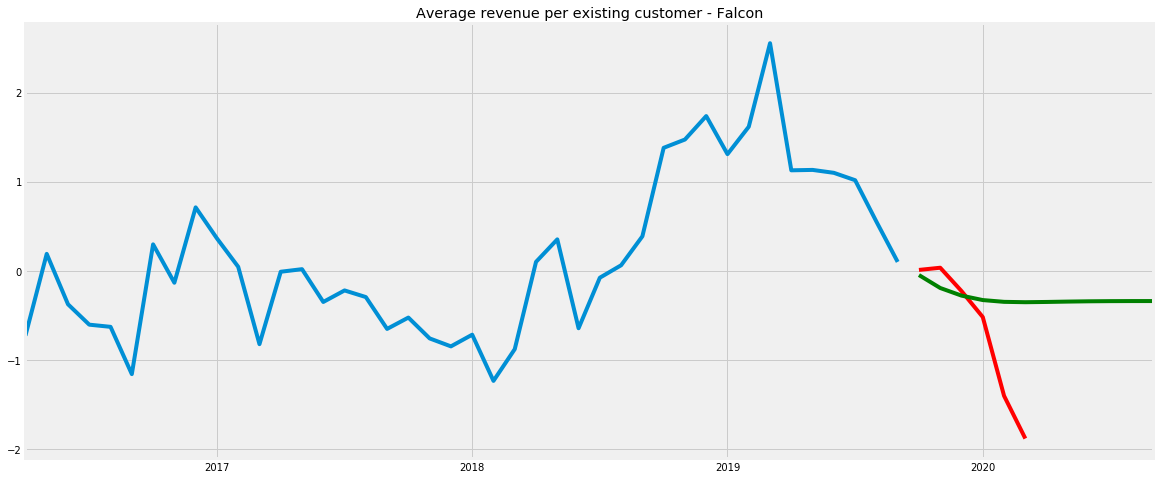

For "desh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)" with model "AUTO"
MAPE : 1.4911606149126928
Threshold : 5.0,  Target: 3.3
Raw score : 0.21490355339098954
Threshold score : 0.07


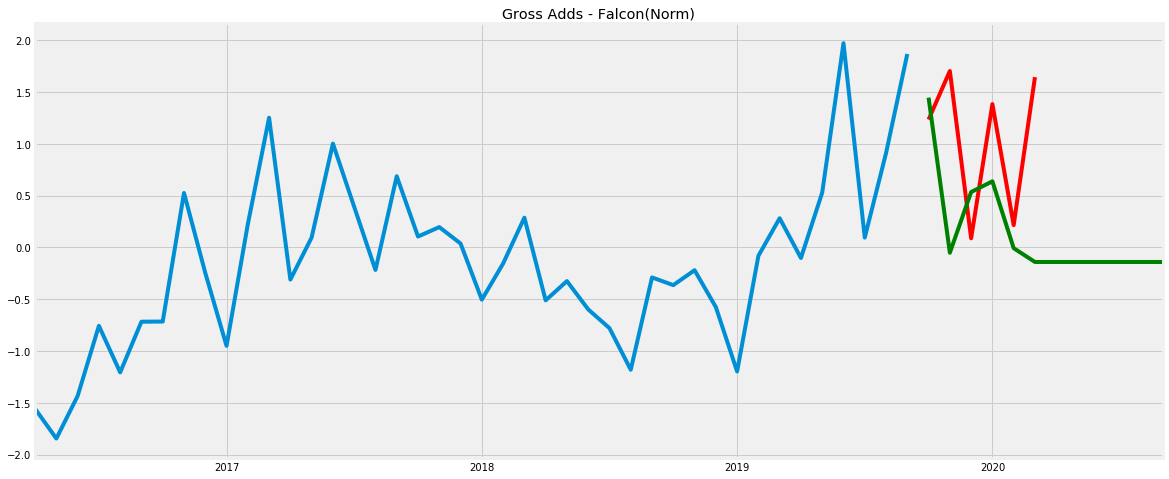

For "desh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)" with model "AUTO"
MAPE : 0.176919414737572
Threshold : 0.25,  Target: 0.18
Raw score : 0.823080585262428
Threshold score : 0.07


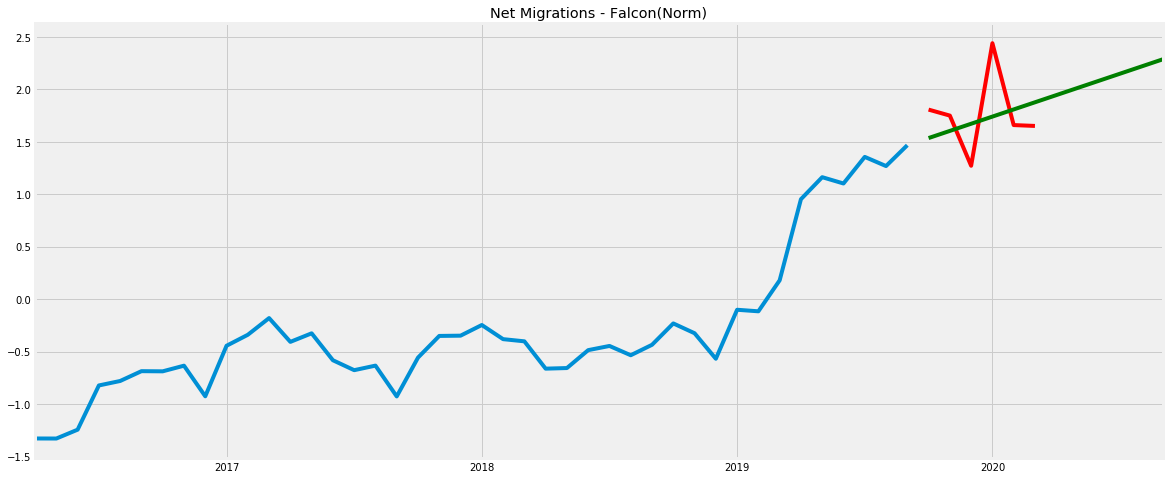

Final Raw score : 0.542938586752476
Final Threshold score : 0.21000000000000002


In [14]:
evaluate(full_forecasts, test_data, target_data, plot=True)

# EDA

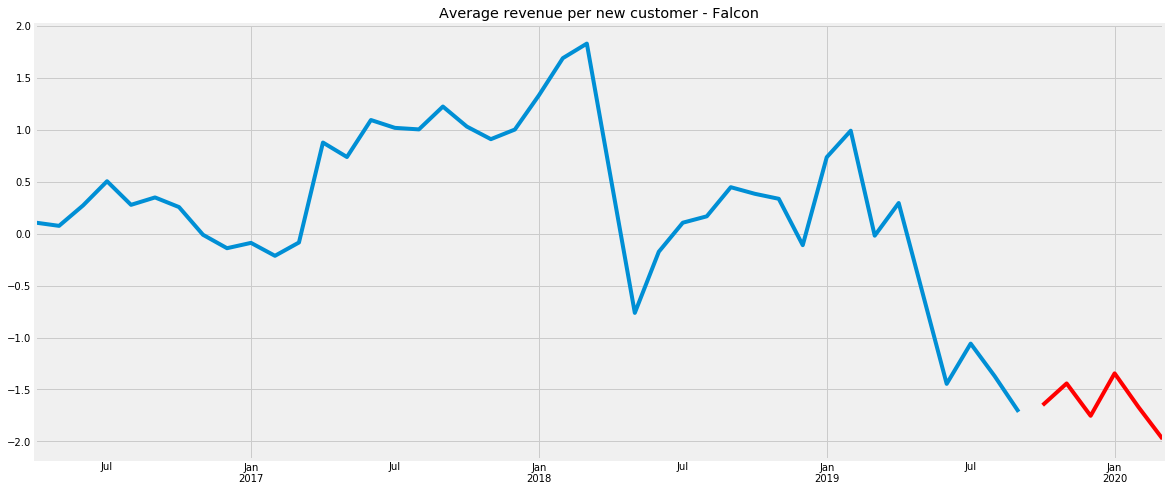

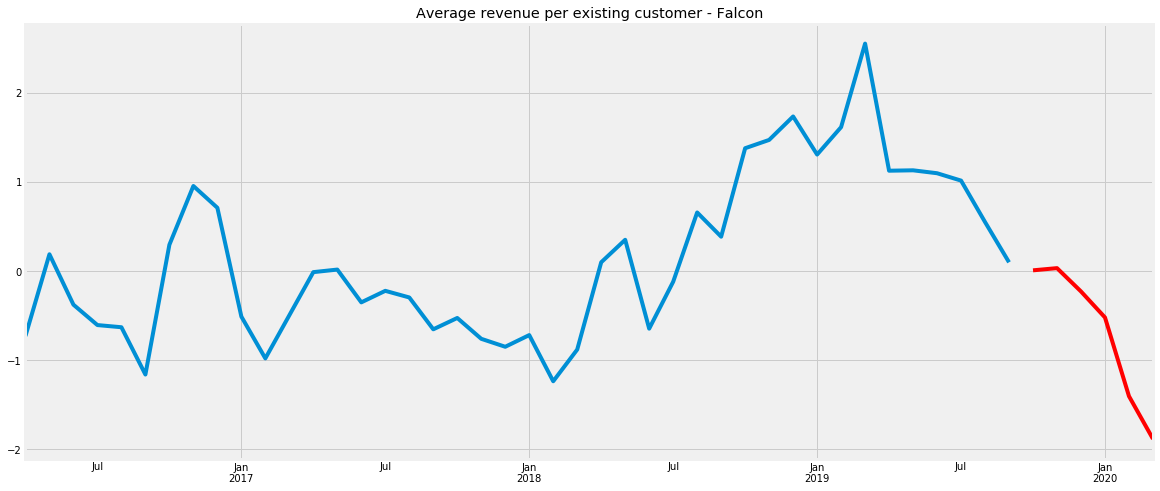

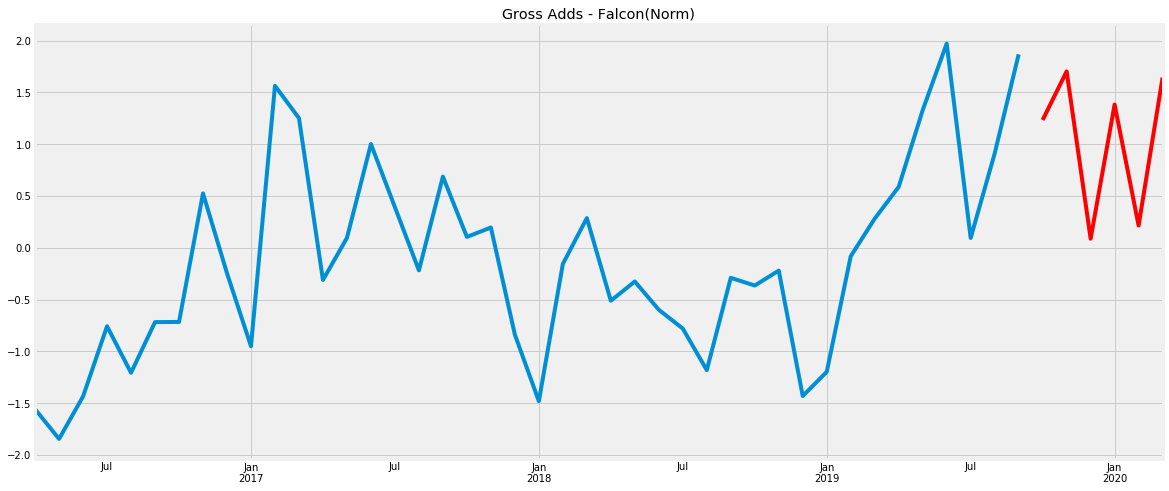

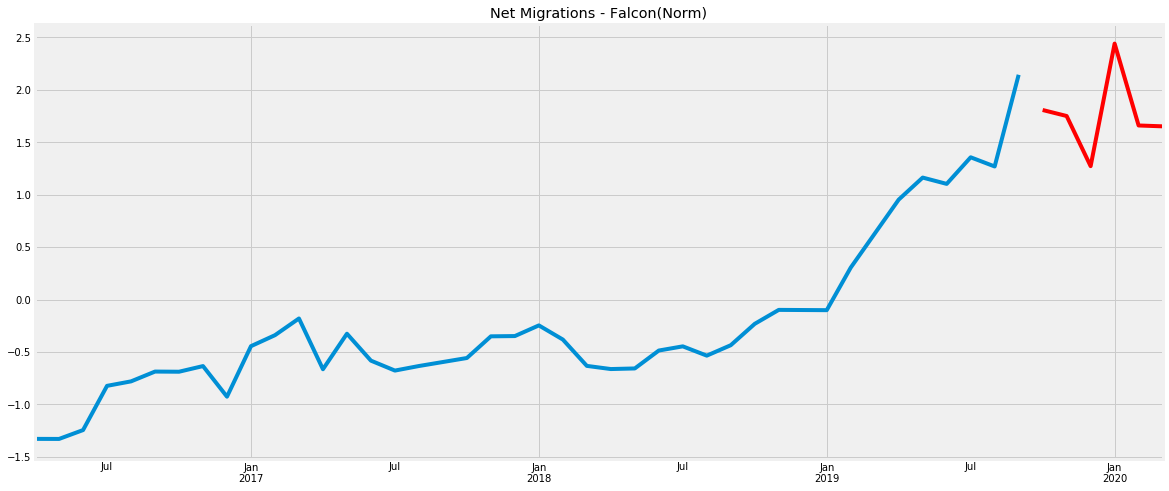

In [15]:
pd.plotting.register_matplotlib_converters()
matplotlib.rcParams['figure.figsize'] = 18, 8

for i in target_data.columns:
    plt.figure()
    plt.title(i[69:])
    
    target_data[i].plot()
    test_data[i].plot(color='red')

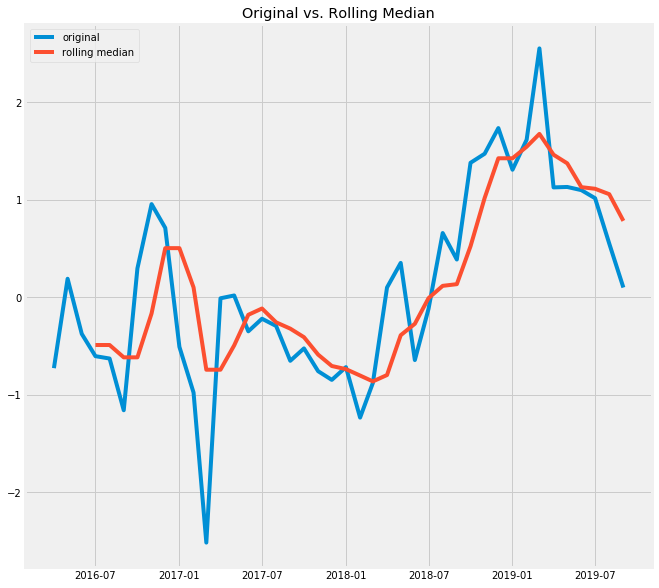

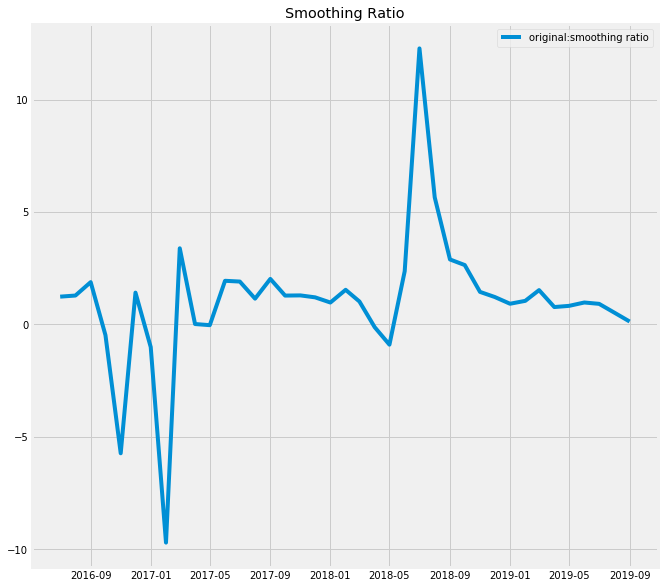

C:\Users\waynn\.conda\envs\tensorflow_cpu\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.



Outliers found at  DatetimeIndex(['2016-11-01', '2017-01-01', '2017-02-01', '2017-03-01',
               '2018-07-01', '2018-08-01'],
              dtype='datetime64[ns]', freq=None)


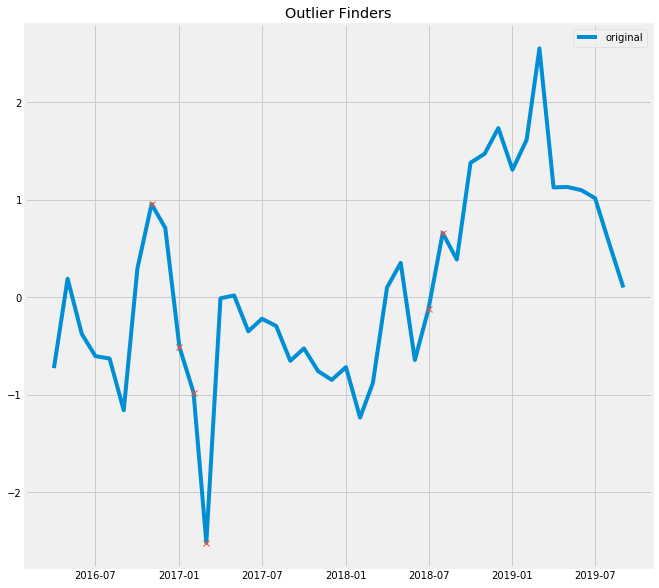

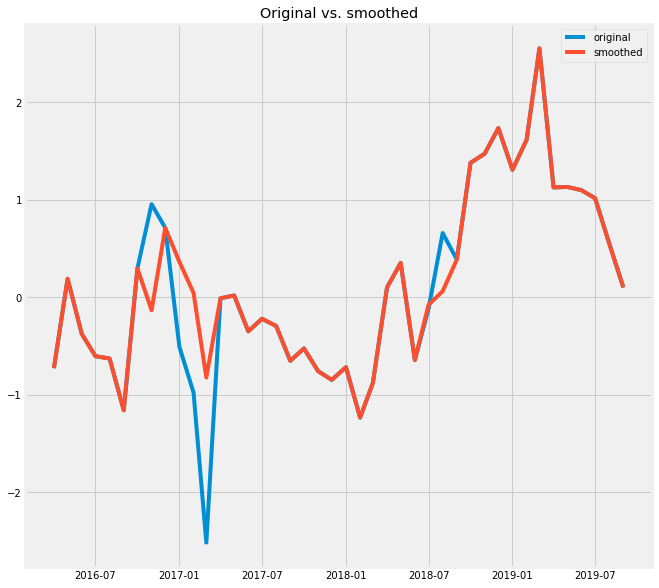

2016-04-01   -0.728341
2016-05-01    0.189526
2016-06-01   -0.376269
2016-07-01   -0.605243
2016-08-01   -0.629582
2016-09-01   -1.160367
2016-10-01    0.296251
2016-11-01   -0.134492
2016-12-01    0.711331
2017-01-01    0.363421
2017-02-01    0.044570
2017-03-01   -0.824157
2017-04-01   -0.011087
2017-05-01    0.017668
2017-06-01   -0.350237
2017-07-01   -0.220951
2017-08-01   -0.295309
2017-09-01   -0.652847
2017-10-01   -0.525569
2017-11-01   -0.759479
2017-12-01   -0.848801
2018-01-01   -0.717755
2018-02-01   -1.236038
2018-03-01   -0.879988
2018-04-01    0.099598
2018-05-01    0.352170
2018-06-01   -0.645459
2018-07-01   -0.078168
2018-08-01    0.061637
2018-09-01    0.386911
2018-10-01    1.379817
2018-11-01    1.472979
2018-12-01    1.736275
2019-01-01    1.308730
2019-02-01    1.616661
2019-03-01    2.554307
2019-04-01    1.127399
2019-05-01    1.131877
2019-06-01    1.099112
2019-07-01    1.016346
2019-08-01    0.551219
2019-09-01    0.099310
Freq: MS, Name: Segment 2Sandesh B

In [19]:
col = target_data.columns[1]
outlier_smoothing(target_data[col])

In [15]:
col = target_data.columns[0]

In [23]:
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import AutoregressionAD
from adtk.transformer import RollingAggregate

In [24]:
s_train = validate_series(target_data)

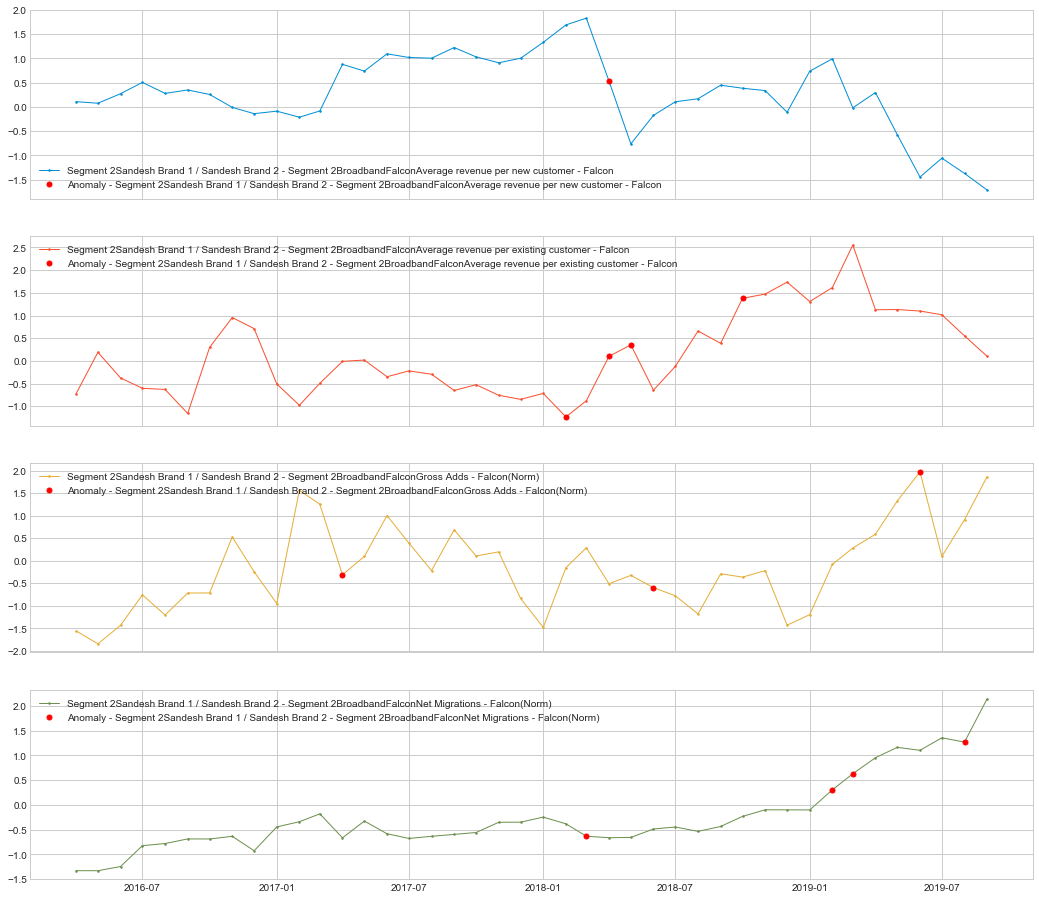

In [25]:
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import AutoregressionAD
from adtk.transformer import RollingAggregate

s_train = validate_series(target_data)

quantile_ad = AutoregressionAD(n_steps=12, step_size=1, c=0.6)
anomalies = quantile_ad.fit_detect(s_train)
plot(s_train, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");
# target_data[anomalies == 1] = np.nan
# target_data.interpolate(inplace = True)

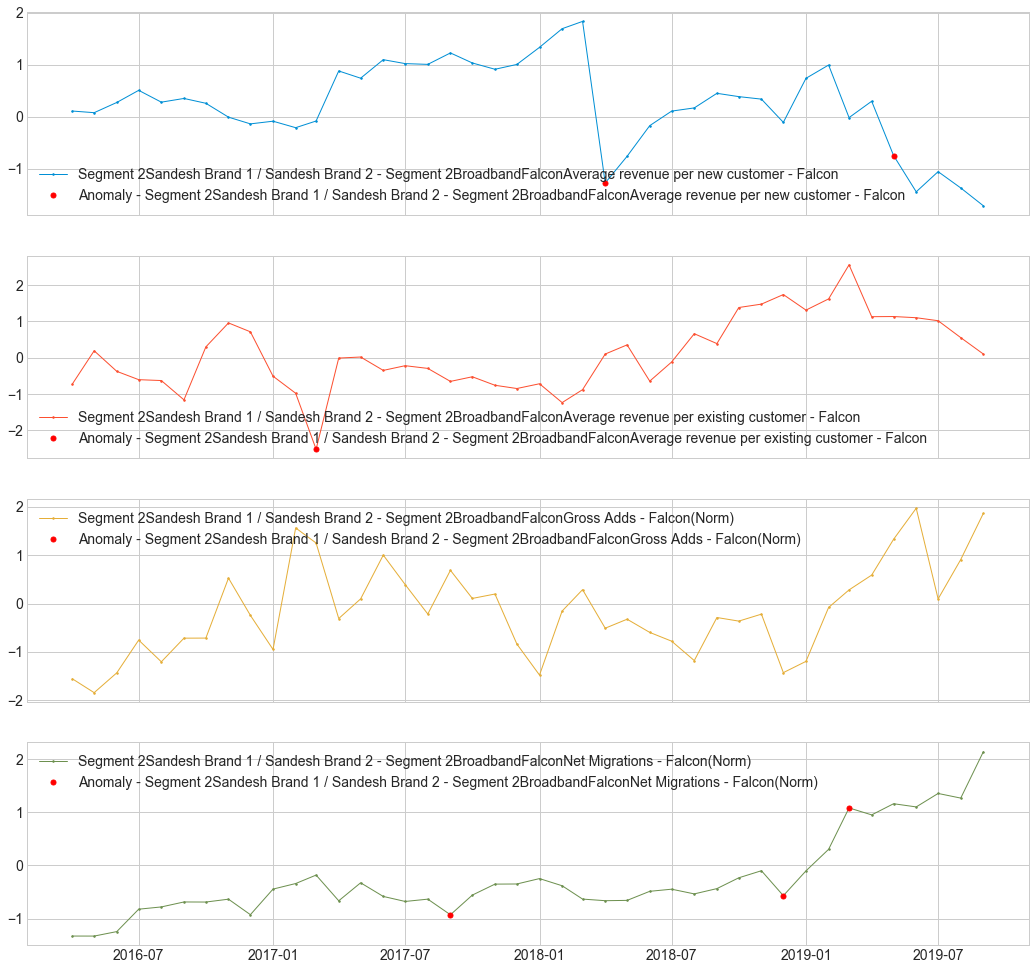

In [125]:
plot(s_train, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

In [110]:
target_data[anomalies == 1] = np.nan

In [121]:
target_data

,Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon,Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon,Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm),Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)
2016-04-01,0.107120,-0.728341,-1.557326,-1.328065
2016-05-01,0.075391,0.189526,-1.845046,-1.328528
2016-06-01,0.271979,-0.376269,-1.434703,-1.244046
2016-07-01,0.505065,-0.605243,-0.757287,-0.822560
2016-08-01,0.277726,-0.629582,-1.206455,-0.779971
2016-09-01,0.349048,-1.160367,-0.717324,-0.686462
2016-10-01,0.256174,0.296251,-0.715757,-0.687967
2016-11-01,-0.010638,0.955728,0.525412,-0.634153
2016-12-01,-0.139911,0.711331,-0.245483,-0.925790
2017-01-01,-0.088569,-0.509628,-0.950544,-0.444357


In [128]:
target_data.interpolate(inplace = True)

In [14]:
target_data

,Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon,Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon,Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm),Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)
2016-04-01,0.107120,-0.728341,-1.557326,-1.328065
2016-05-01,0.075391,0.189526,-1.845046,-1.328528
2016-06-01,0.271979,-0.376269,-1.434703,-1.244046
2016-07-01,0.505065,-0.605243,-0.757287,-0.822560
2016-08-01,0.277726,-0.629582,-1.206455,-0.779971
2016-09-01,0.349048,-1.160367,-0.717324,-0.686462
2016-10-01,0.256174,0.296251,-0.715757,-0.687967
2016-11-01,-0.010638,0.955728,0.525412,-0.634153
2016-12-01,-0.139911,0.711331,-0.245483,-0.925790
2017-01-01,-0.088569,-0.509628,-0.950544,-0.444357
